In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
from geofunctions import utils
import os

In [4]:
import importlib

importlib.reload(utils)

<module 'geofunctions.utils' from '/Users/inessat/Documents/phd/empirics/israel/notebooks/phd-remote-work/geofunctions/utils.py'>

In [5]:
months = utils.return_list_months_ok()

In [41]:
geohash_stat_area = gpd.read_file(
    utils.get_path("processed", "adm", "geohash_stat_area_pairs.geojson")
)

In [7]:
list_df = []

In [42]:
months_files = os.listdir(utils.get_path("processed", "dwells", "work"))
months_files = [f for f in months_files if f.endswith(".csv")]

In [ ]:
for monthly_file in sorted(months_files):

    MONTH = monthly_file.split("_")[-1][:-4]
    print(MONTH)
    df = pd.read_csv(
        utils.get_path("processed", "dwells", f"work/{monthly_file}"), index_col=0
    )

    work_home_matrix = df.groupby(["geohash_home", "geohash_work"])["work_date"].agg(
        ["count", "sum"]
    )
    work_home_matrix.columns = ["users", "days"]
    work_home_matrix = work_home_matrix.reset_index()

    # Work-home matrix on statistical areas
    work_home_matrix_statarea = work_home_matrix.merge(
        geohash_stat_area[["geohash", "geometry", "YISHUV_STAT_2022"]],
        left_on="geohash_home",
        right_on="geohash",
    )
    work_home_matrix_statarea = work_home_matrix_statarea.drop("geohash", axis=1)
    work_home_matrix_statarea = work_home_matrix_statarea.merge(
        geohash_stat_area[["geohash", "geometry", "YISHUV_STAT_2022"]],
        left_on="geohash_work",
        right_on="geohash",
        suffixes=("_home", "_work"),
    )
    work_home_matrix_statarea = work_home_matrix_statarea.drop("geohash", axis=1)
    work_home_matrix_statarea_agg = (
        work_home_matrix_statarea.groupby(
            [
                "YISHUV_STAT_2022_home",
                "geometry_home",
                "YISHUV_STAT_2022_work",
                "geometry_work",
            ]
        )[["users", "days"]]
        .sum()
        .reset_index()
    )

    # Add direction between work and home
    from shapely.geometry import LineString

    work_home_matrix_statarea_agg["geometry_line"] = (
        work_home_matrix_statarea_agg.apply(
            lambda row: (
                LineString(
                    [row["geometry_home"].centroid, row["geometry_work"].centroid]
                )
                if row["geometry_home"] is not None and row["geometry_work"] is not None
                else None
            ),
            axis=1,
        )
    )
    work_home_matrix_statarea_agg["distance"] = (
        gpd.GeoSeries(work_home_matrix_statarea_agg["geometry_line"], crs=4326)
        .to_crs(2039)
        .length
    )
    work_home_matrix_statarea_agg["month"] = MONTH
    list_df.append(work_home_matrix_statarea_agg)

201909
201911
201912
202001
202002
202003
202004
202005
202006
202007
202008
202009
202010
202101
202104
202106
202107
202109
202110
202111
202201
202203
202204
202207
202210
202211
202301
202302
202303
202304
202305
202306
202309


In [44]:
matrix_df = pd.concat(list_df)

In [25]:
matrix_df.head()

,YISHUV_STAT_2022_home,geometry_home,YISHUV_STAT_2022_work,geometry_work,users,days,geometry_line,distance,month
0,5516,"POLYGON ((34.89532 32.31766, 34.89532 32.31903...",74000121,"POLYGON ((34.86511 32.28882, 34.86511 32.29019...",1,8,LINESTRING (34.89601135253906 32.3183441162109...,4280.725546,202001
1,5516,"POLYGON ((34.89532 32.31766, 34.89532 32.31903...",87000036,"POLYGON ((34.88159 32.17758, 34.88159 32.17896...",1,2,LINESTRING (34.89601135253906 32.3183441162109...,15587.333742,202001
2,5516,"POLYGON ((34.86649 32.36023, 34.86649 32.3616,...",13180001,"POLYGON ((34.86786 32.40417, 34.86786 32.40555...",1,12,LINESTRING (34.86717224121094 32.3609161376953...,4875.083637,202001
3,5516,"POLYGON ((34.8555 32.35199, 34.8555 32.35336, ...",13180001,"POLYGON ((34.86786 32.40417, 34.86786 32.40555...",1,8,LINESTRING (34.85618591308594 32.3526763916015...,5902.849660,202001
4,5516,"POLYGON ((34.87198 32.40143, 34.87198 32.4028,...",26500021,"POLYGON ((34.84039 32.13776, 34.84039 32.13913...",1,3,LINESTRING (34.87266540527344 32.4021148681640...,29390.775086,202001


In [ ]:
matrix_df.groupby("month")["users"].sum()

month
201909     5244
201911     3722
201912     2426
202001    78813
202002     3936
202003    11332
202004     1846
202005    29146
202006    24731
202007    22772
202008    44682
202009    95613
202010    30760
202101    38556
202104    23106
202106     5197
202107    10662
202109     2924
202110     4520
202111     2156
202201    24182
202203    18611
202204    24524
202207    62674
202210    59084
202211    30723
202301    67916
202302    34459
202303    78450
202304    42498
202305    38492
202306    38626
202309    43286
Name: users, dtype: int64

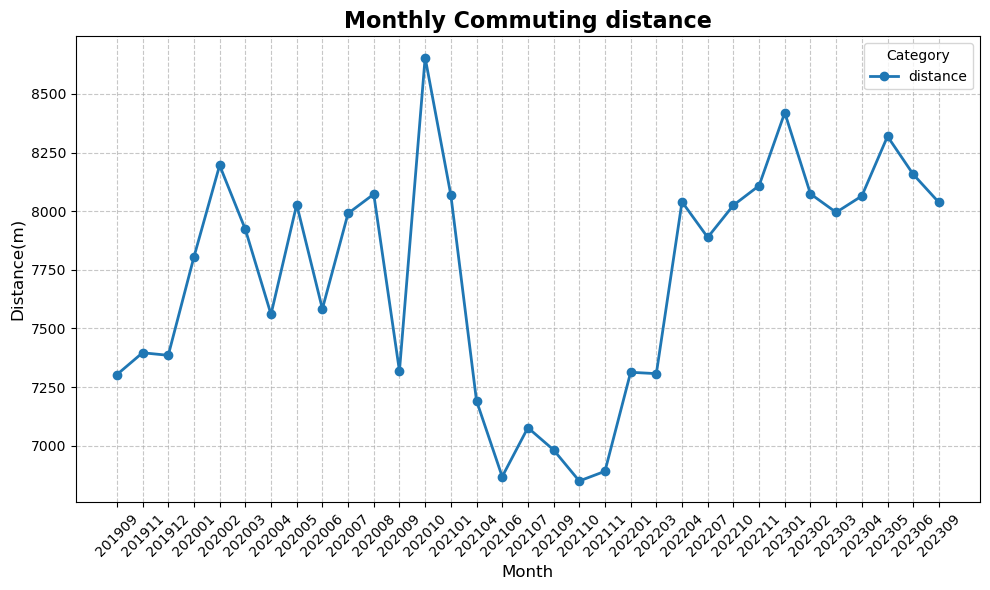

In [ ]:
import matplotlib.pyplot as plt

# Grouping and plotting
ax = (
    matrix_df.groupby("month")["distance"]
    .mean()
    .plot(
        figsize=(10, 6),  # Adjust the figure size
        marker="o",  # Add markers to the lines
        linestyle="-",  # Set line style
        linewidth=2,  # Set line width
    )
)

# Customize the plot
ax.set_title("Monthly Commuting distance", fontsize=16, fontweight="bold")
ax.set_xlabel("Month", fontsize=12)
ax.set_ylabel("Distance(m)", fontsize=12)
ax.legend(title="Category", fontsize=10)
ax.grid(visible=True, linestyle="--", alpha=0.7)  # Add a grid

# Add a red dashed horizontal line at y=5000
# plt.axhline(y=5000, color='red', linestyle='--', linewidth=1.5, label='Threshold: 5000')

# Make the x-axis labels more readable if 'month' is not numerical
months = sorted(
    matrix_df["month"].unique().tolist()
)  # Extract unique months  # Spread ticks evenly
ax.set_xticks(range(len(months)))
ax.set_xticklabels(months, rotation=45, fontsize=10)
# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

In [ ]:
matrix_df.to_csv(
    utils.get_path(
        "processed", "dwells", "data_statistics/stat_area_commuting_pairs_monthly.csv"
    )
)